<h1>Домашнее задание 4</h1>

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from IPython.display import Image
#from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
#from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# Чтение данных
df = pd.read_csv('data.csv')

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [2]:
df['target'] = df['conversion']
df['treatment'] = df['offer']

del df['conversion']
del df['offer']

df['treatment'] = df.treatment.apply(lambda x: 0 if x == 'No Offer' else 1) 

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,target,treatment
0,10,142.44,1,0,Surburban,0,Phone,0,1
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,0,1
3,9,675.83,1,0,Rural,1,Web,0,1
4,2,45.34,1,0,Urban,0,Web,0,1


сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

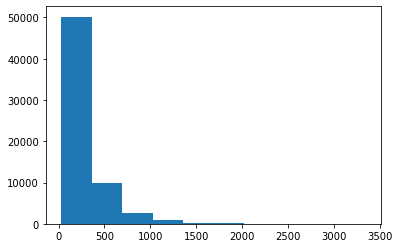

In [3]:
plt.hist(df['history'])
plt.show()

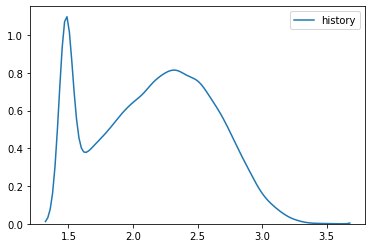

In [4]:
sns.kdeplot(np.log10(df['history']))
plt.show()

In [5]:
df['history'] = np.log10(df['history'])
df['history'] = df.history.apply(lambda x: 1.5 if x <= 1.5 else x)
df['history'] = df.history.apply(lambda x: 2 if x > 1.5 and x <= 2 else x)
df['history'] = df.history.apply(lambda x: 2.5 if x > 2 and x <= 2.5 else x)
df['history'] = df.history.apply(lambda x: 3 if x > 2.5 else x)
df['history'].value_counts()

2.5    24379
3.0    16649
2.0    14584
1.5     8388
Name: history, dtype: int64

In [6]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [7]:
df['channel_one'] = df.channel.apply(lambda x: 0 if x == 'Multichannel' else 1) 
df['channel_one'].value_counts()

1    56238
0     7762
Name: channel_one, dtype: int64

In [8]:
df['channel'] = df.channel.apply(lambda x: 1 if x == 'Web' else x)
df['channel'] = df.channel.apply(lambda x: 2 if x == 'Phone' else x)
df['channel'] = df.channel.apply(lambda x: 3 if x == 'Multichannel' else x)
df['channel'].value_counts()

1    28217
2    28021
3     7762
Name: channel, dtype: int64

In [9]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [10]:
df['zip_code'] = df.zip_code.apply(lambda x: 1 if x == 'Surburban' else x)
df['zip_code'] = df.zip_code.apply(lambda x: 2 if x == 'Urban' else x)
df['zip_code'] = df.zip_code.apply(lambda x: 3 if x == 'Rural' else x)
df['zip_code'].value_counts()

1    28776
2    25661
3     9563
Name: zip_code, dtype: int64

In [11]:
pl = PolynomialFeatures(degree=2)
x_new = pl.fit_transform(df.loc[:,['channel','zip_code']])
x_new

array([[1., 2., 1., 4., 2., 1.],
       [1., 1., 3., 1., 3., 9.],
       [1., 1., 1., 1., 1., 1.],
       ...,
       [1., 2., 2., 4., 4., 4.],
       [1., 3., 1., 9., 3., 1.],
       [1., 1., 1., 1., 1., 1.]])

сделать разбиение набора данных не тренировочную и тестовую выборки

In [12]:
#indices_train = df_train.index
#indices_test = df_test.index
df_train, df_test = train_test_split(df, test_size=0.3, random_state=123)

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [13]:
cat_features = ['zip_code', 'channel', 'channel_one', 'recency']
num_features = ['history','used_discount', 'used_bogo', 'is_referral']

y_train = df_train['target']
treat_train = df_train['treatment']

X_train = df_train[cat_features + num_features]

y_val = df_test['target']
treat_val = df_test['treatment']

X_val = df_test[cat_features + num_features]

In [14]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,target,treatment,channel_one
0,10,2.5,1,0,1,0,2,0,1,1
1,6,3.0,1,1,3,1,1,0,0,1
2,7,2.5,0,1,1,1,1,0,1,1
3,9,3.0,1,0,3,1,1,0,1,1
4,2,2.0,1,0,2,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
63995,10,2.5,1,0,2,0,1,0,1,1
63996,5,2.0,0,1,2,1,2,0,1,1
63997,6,1.5,1,0,2,1,2,0,1,1
63998,1,3.0,1,0,1,1,3,0,1,0


провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

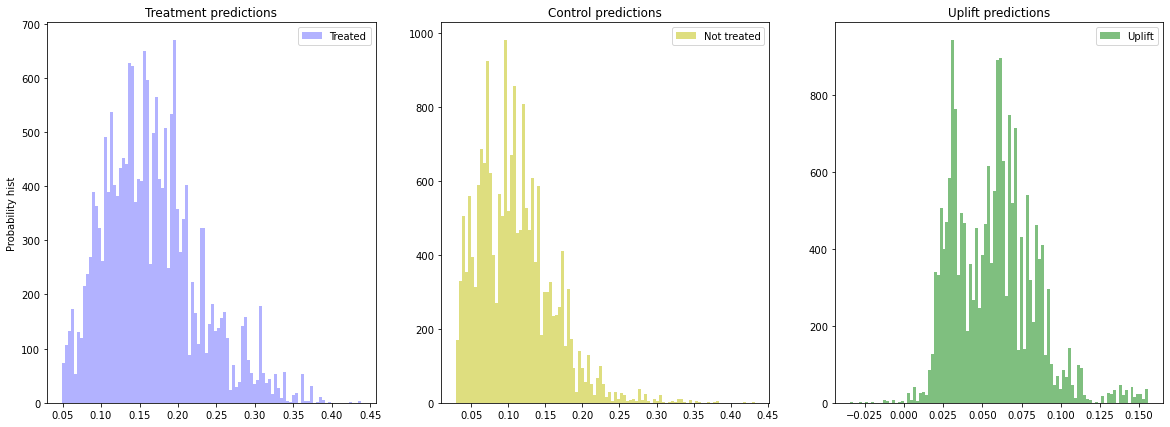

In [15]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [16]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

<ipython-input-16-c1d124b839bb>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


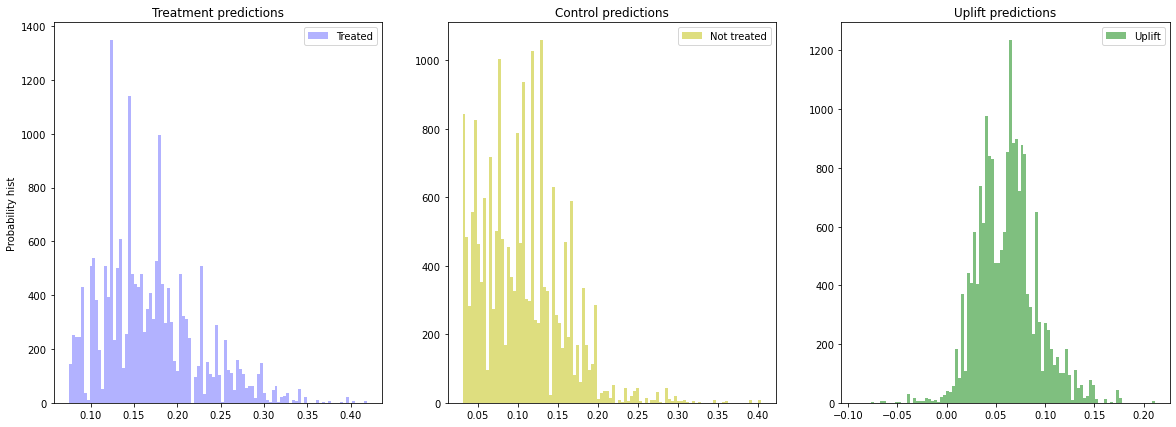

In [17]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [18]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.111936,0.097362
0,SoloModel,0.086116,0.077039
2,TwoModels,0.079079,0.080548


построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

<b>К сожалению ушло слишком много времени на попытку подключения causalml (следовало пойти путем через google сервис), победить не удалось, по этому описание дерева предоставить не успеваю. Если судить по материалам лекуии, то по узлам дерева мы можем судить о наиболее важных фичах в разных узлах дерева при построение схемы uplift_tree_plot.</b>

In [19]:
%%time

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

NameError: name 'UpliftTreeClassifier' is not defined